In [10]:
"""
Exp03A: None & Risk-off Gate 

Goal:
- Test if risk-off gate can reduce drawdowns during stressed periods.
- Isolate the effect of risk-off gate, without mixing in volatility targeting.


Fixed:
- Asset: SPY
- Signal: MA (same as Exp02 baseline, e.g., MA=60)
- Risk: vol_target - off


Risk-off Gate Rule:
- Rolling realized volatility gate
    - If `realized_vol > threshold` → risk-off


Evaluation:
- Max Drawdown (primary)
- Sharpe / Annual Return (secondary)
- Turnover impact (check if gate increases churn)
- Regime breakdown (especially 2022 / stressed slices)


"""

'\nExp03A: None & Risk-off Gate \n\nGoal:\n- Test if risk-off gate can reduce drawdowns during stressed periods.\n- Isolate the effect of risk-off gate, without mixing in volatility targeting.\n\n\nFixed:\n- Asset: SPY\n- Signal: MA (same as Exp02 baseline, e.g., MA=60)\n- Risk: vol_target - off\n\n\nRisk-off Gate Rule:\n- Rolling realized volatility gate\n    - If `realized_vol > threshold` → risk-off\n\n\nEvaluation:\n- Max Drawdown (primary)\n- Sharpe / Annual Return (secondary)\n- Turnover impact (check if gate increases churn)\n- Regime breakdown (especially 2022 / stressed slices)\n\n\n'

In [11]:
import os
os.chdir("/Users/kim/Desktop/Quant-Research")
print(os.getcwd())

# os.chdir("..")
# print(os.getcwd())

/Users/kim/Desktop/Quant-Research


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from config import Config
from runner import run
from risk.risk_off_gate import risk_off_gate_vol

In [13]:
### baseline:  config
from dataclasses import replace
cfg_base = replace(Config(), 
                   RISK_MODE="none", # # Exp03A: isolate gate effect (vol_target: off)
                   MA_WINDOW=80   # 和Exp02同
                  )   

In [14]:

# -------------------------
# 1) baseline (no gate)
# -------------------------
cfg0 = replace(cfg_base, USE_RISK_OFF_GATE=False)
res0, s0 = run(cfg0)

# -------------------------
# 2) with risk-off gate
# -------------------------
cfg1 = replace(
    cfg_base,
    USE_RISK_OFF_GATE=True,
    GATE_LOOKBACK=10,
    GATE_VOL_THRESHOLD_ANNUAL=0.15,   # 先用一个合理初值，后面再 sweep
)
res1, s1 = run(cfg1)

# -------------------------
# 3) summary comparison
# -------------------------
exp03a = pd.DataFrame([
    {"mode": "baseline_no_gate", **s0},
    {"mode": "risk_off_gate", **s1},
]).set_index("mode")

exp03a

/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  idx = pd.to_datetime(df.index, errors="coerce")
/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed in

,Annual Return,Max Drawdown,Sharpe,Total Turnover,N_obs
mode,,,,,
baseline_no_gate,0.069690,-0.192385,0.663331,108.0,2436
risk_off_gate,0.054044,-0.150380,0.654023,113.0,2436


In [15]:
# -------------------------
# helper: drawdown curve
# -------------------------
def drawdown_curve(equity: pd.Series) -> pd.Series:
    cm = equity.cummax()
    return equity / cm - 1

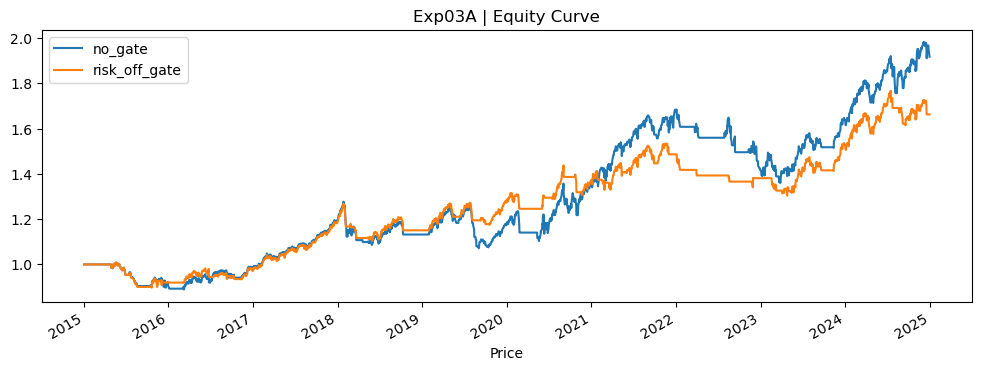

In [16]:
### (1) Equity curve

plt.figure(figsize=(12,4))
res0["equity"].plot(label="no_gate")
res1["equity"].plot(label="risk_off_gate")
plt.title("Exp03A | Equity Curve")
plt.legend()
plt.show()


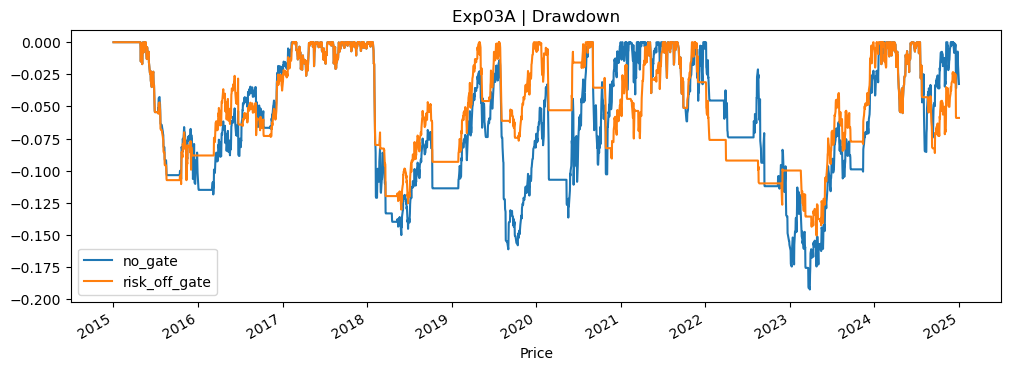

In [17]:
### (2) Drawdown curve
plt.figure(figsize=(12,4))
drawdown_curve(res0["equity"]).plot(label="no_gate")
drawdown_curve(res1["equity"]).plot(label="risk_off_gate")
plt.title("Exp03A | Drawdown")
plt.legend()
plt.show()


Gate value counts (normalized):
gate
0.0    0.346979
1.0    0.653021
Name: proportion, dtype: float64


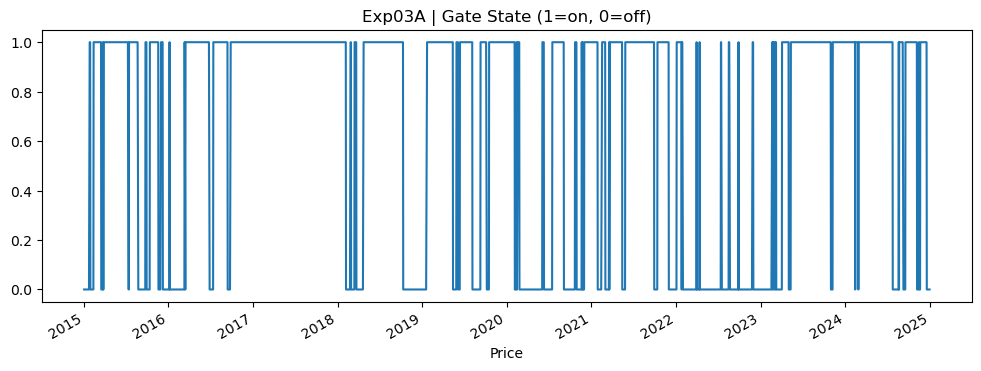

In [18]:
### (3) Gate 行为（触发频率 + 时间序列）
# 触发比例（0=off, 1=on）
if "gate" in res1.columns:
    print("Gate value counts (normalized):")
    print(res1["gate"].value_counts(normalize=True).sort_index())

    plt.figure(figsize=(12,4))
    res1["gate"].plot(title="Exp03A | Gate State (1=on, 0=off)")
    plt.show()
else:
    print("No 'gate' column found in res1. Make sure you added result['gate'] in runner.")
